#libraries

In [ ]:
# Data manipulation and preprocessing
import numpy as np
import pandas as pd
import string
import nltk
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

# TensorFlow and Keras imports for model building
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Attention, Dense, Dropout, Concatenate, Input, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# File and directory management
import os
import shutil

# Kaggle related functionality
import kagglehub


#downlod_imdb

In [6]:
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:00<00:00, 61.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [ ]:
new_path = "/content/imdb_dataset"
os.makedirs(new_path, exist_ok=True)
shutil.move(path, new_path)

In [8]:
file_path = os.path.join("/content/imdb_dataset/1/IMDB Dataset.csv")  # یا نام فایل را جایگزین کنید
df = pd.read_csv(file_path)

# نمایش چند ردیف ابتدایی
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


#data_analys

In [9]:
df = df.drop_duplicates()
print(f"New shape after removing duplicates: {df.shape}")

New shape after removing duplicates: (49582, 2)


In [10]:
# نمایش اطلاعات کلی دیتاست
print("Dataset Info:")
print(df.info())

# نمایش تعداد نمونه‌ها و ستون‌ها
print(f"Shape of dataset: {df.shape}")

# نمایش نام ستون‌ها
print("Columns:", df.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
Shape of dataset: (49582, 2)
Columns: Index(['review', 'sentiment'], dtype='object')


In [11]:
print("Category distribution:")
print(df['sentiment'].value_counts())

Category distribution:
sentiment
positive    24884
negative    24698
Name: count, dtype: int64


In [12]:
df['text_length'] = df['review'].apply(len)
print("Text length statistics:")
print(df['text_length'].describe())

Text length statistics:
count    49582.000000
mean      1310.568230
std        990.762238
min         32.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: text_length, dtype: float64


In [13]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [14]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
review         0
sentiment      0
text_length    0
dtype: int64


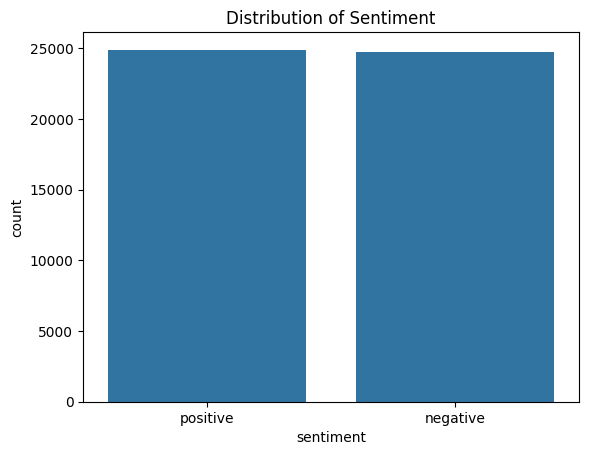

In [15]:

sns.countplot(x='sentiment', data=df)
plt.title("Distribution of Sentiment")
plt.show()

#preprpcess

In [18]:
# دانلود منابع NLTK
nltk.download('stopwords')

# تعریف تابع پیش‌پردازش
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # تبدیل به حروف کوچک
    text = text.translate(str.maketrans('', '', string.punctuation))  # حذف علائم نگارشی
    words = text.split()  # تقسیم متن به کلمات
    words = [word for word in words if word not in stop_words]  # حذف کلمات بی‌معنی
    return ' '.join(words)

# پیش‌پردازش داده‌ها
df['processed_review'] = df['review'].apply(preprocess_text)

# نمایش چند نمونه
print(df['processed_review'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: processed_review, dtype: object


In [19]:
# تقسیم داده‌ها به آموزش و تست (80% آموزش، 20% تست)
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)

# تقسیم داده‌های آموزش به آموزش و اعتبارسنجی (80% آموزش، 20% اعتبارسنجی)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)} samples")
print(f"Validation data: {len(X_val)} samples")
print(f"Test data: {len(X_test)} samples")

Training data: 31732 samples
Validation data: 7933 samples
Test data: 9917 samples


In [20]:
# استفاده از Tokenizer برای توکن‌سازی داده‌ها
tokenizer = Tokenizer(num_words=10000)  # حداکثر 10000 کلمه پرتکرار
tokenizer.fit_on_texts(X_train)  # آموزش توکنایزر روی داده‌های آموزشی

# تبدیل متن‌ها به توکن‌های عددی
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# پدینگ توکن‌ها برای یکسان کردن طول آنها
max_len = 200  # حداکثر طول هر متن (می‌توانید این مقدار را تغییر دهید)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print(f"Shape of padded training data: {X_train_pad.shape}")
print(f"Shape of padded validation data: {X_val_pad.shape}")
print(f"Shape of padded test data: {X_test_pad.shape}")

Shape of padded training data: (31732, 200)
Shape of padded validation data: (7933, 200)
Shape of padded test data: (9917, 200)


In [21]:
# تبدیل برچسب‌ها به عددی
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

#Hyperparamet

In [ ]:
# تابع برای ساخت مدل
def create_model(num_layers=1, learning_rate=0.001, dropout_rate=0.5):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=10000, output_dim=128, input_length=max_len)(inputs)

    for _ in range(num_layers):
        x_lstm = LSTM(128, return_sequences=True)(x)
        attention_output = Attention()([x_lstm, x_lstm])
        x = Concatenate()([x_lstm, attention_output])

    x = LSTM(128)(x)
    x = Dropout(dropout_rate)(x)  # Dropout for regularization
    x = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# پارامترهای مختلف برای تست
param_grid = {
    'num_layers': [1, 2, 3],  # تعداد لایه‌ها
    'learning_rate': [0.0001, 0.001, 0.01],  # نرخ یادگیری
    'dropout_rate': [0.3, 0.5, 0.7],  # درصد Dropout
}

# تعریف EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# تبدیل داده‌ها به tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_pad, y_test))

# استفاده از 10 درصد داده‌ها برای آموزش
train_dataset = train_dataset.take(int(0.1 * len(X_train)))

# جستجوی پارامترهای مختلف
best_acc = 0
best_params = None

# انجام Grid Search
for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")

    # ایجاد مدل با پارامترهای مختلف
    model = create_model(num_layers=params['num_layers'], learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])

    # آموزش مدل
    history = model.fit(
        train_dataset.batch(64), epochs=5, validation_data=val_dataset.batch(64),
        callbacks=[early_stopping], verbose=1
    )

    # ارزیابی مدل روی داده‌های تست
    test_loss, test_acc = model.evaluate(test_dataset.batch(64))
    print(f"Test accuracy for {params}: {test_acc}")

    # انتخاب بهترین مدل بر اساس دقت
    if test_acc > best_acc:
        best_acc = test_acc
        best_params = params

# نمایش بهترین پارامترها و دقت
print(f"Best accuracy: {best_acc}")
print(f"Best parameters: {best_params}")


Training with params: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'num_layers': 1}
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.5087 - loss: 0.6924 - val_accuracy: 0.5067 - val_loss: 0.6928
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5357 - loss: 0.6894 - val_accuracy: 0.5746 - val_loss: 0.6830
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6818 - loss: 0.6223 - val_accuracy: 0.7728 - val_loss: 0.4601
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8660 - loss: 0.3391 - val_accuracy: 0.8197 - val_loss: 0.4141
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9263 - loss: 0.1899 - val_accuracy: 0.8257 - val_loss: 0.4213
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 398ms/step - accuracy: 0.8153 - loss: 0.4105
Test accuracy for {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'num_layers': 1}: 0.8131491541862488
Training with params: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'num_layers': 2}
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.5200 - loss: 0.6926 - val_accuracy: 0.5175 - val_l

#Model

In [22]:

# شناسایی TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f"Running on TPU: {tpu.master()}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not found. Using default strategy.")
    strategy = tf.distribute.get_strategy()

print(f"Number of replicas: {strategy.num_replicas_in_sync}")

Running on TPU: 
Number of replicas: 8


In [25]:
# تنظیمات اولیه
max_len = 200
vocab_size = 10000
embedding_dim = 128
hyperparams = {'dropout_rate': 0.5, 'learning_rate': 0.001, 'num_layers': 1}

# تقسیم داده‌ها به آموزش، اعتبارسنجی و تست
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# استفاده از Tokenizer برای توکن‌سازی داده‌ها
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# تبدیل متن‌ها به توکن‌های عددی
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# پدینگ توکن‌ها
max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# تبدیل برچسب‌ها به عددی
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

# تبدیل به tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_pad, y_test))

train_dataset = train_dataset.batch(32).shuffle(1000)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

# تابع ایجاد مدل
def create_model(num_layers=2, learning_rate=0.001, vocab_size=5000, embedding_dim=128, sequence_length=200):
    input_layer = Input(shape=(sequence_length,))

    # لایه embedding
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    # لایه‌های LSTM و توجه
    x = embedding_layer
    for _ in range(num_layers):
        x = LSTM(128, return_sequences=True)(x)
        attention_layer = Attention()([x, x])  # اعمال توجه
        x = Concatenate()([x, attention_layer])

    x = Reshape((-1, 256))(x)  # تغییر شکل خروجی
    x = LSTM(128)(x)  # LSTM نهایی

    # لایه‌های Dropout و Dense
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # ساخت مدل
    model = Model(inputs=input_layer, outputs=output_layer)

    # کامپایل مدل
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# تعریف EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# ساخت مدل با مکانیزم توجه
with strategy.scope():
    model = create_model(num_layers=2, learning_rate=0.001)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # آموزش مدل با داده‌ها و اضافه کردن EarlyStopping
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping])

    # ارزیابی مدل روی داده‌های تست
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc}")


Epoch 1/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 61s 54ms/step - accuracy: 0.7837 - loss: 0.4274 - val_accuracy: 0.8790 - val_loss: 0.2958
Epoch 2/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9193 - loss: 0.2146 - val_accuracy: 0.8841 - val_loss: 0.2812
Epoch 3/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9444 - loss: 0.1537 - val_accuracy: 0.8790 - val_loss: 0.3011
Epoch 4/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9565 - loss: 0.1237 - val_accuracy: 0.8841 - val_loss: 0.3310
Epoch 5/50
992/992 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9611 - loss: 0.1042 - val_accuracy: 0.8780 - val_loss: 0.3414
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8707 - loss: 0.3137
Test accuracy: 0.874193549156189


In [26]:
model.summary()  # بررسی معماری مدل

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 200, 128)       │        640,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 200, 128)       │        131,584 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 200, 128)       │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 200, 256)       │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 200, 128)       │        197,120 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, 200, 128)       │              0 │ lstm_4[0][0],          │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 200, 256)       │              0 │ lstm_4[0][0],          │
│ (Concatenate)             │                        │                │ attention_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 200, 256)       │              0 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 128)            │        197,120 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,497,861 (13.34 MB)

 Trainable params: 1,165,953 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,331,908 (8.90 MB)

In [30]:
# ذخیره مدل
model_save_path = "attention_model.h5"
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at attention_model.h5


In [31]:
# بارگذاری مدل ذخیره شده
with strategy.scope():
    loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'Attention': Attention})

In [32]:
# ارزیابی مدل
test_loss, test_acc = loaded_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")


310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8595 - loss: 0.4094
Test Accuracy: 0.8637096881866455


In [33]:
# استخراج وزن‌های توجه با استفاده از استراتژی
def extract_attention_weights(model, sample_input, strategy):
    with strategy.scope():
        attention_layer = [layer for layer in model.layers if isinstance(layer, Attention)][0]
        attention_model = Model(inputs=model.input, outputs=attention_layer.output)
        return attention_model.predict(sample_input)

# دسته‌بندی نمونه‌ها و نمایش نتایج
sample_texts = ["The movie was fantastic!", "I didn’t enjoy the film at all."]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=max_len)

# استخراج وزن‌های توجه
attention_weights = extract_attention_weights(loaded_model, sample_padded, strategy)

# پیش‌بینی و نمایش نتایج
predictions = loaded_model.predict(sample_padded)

for text, pred, weights in zip(sample_texts, predictions, attention_weights):
    sentiment = "Positive" if pred > 0.5 else "Negative"
    print(f"Review: {text}\nPredicted Sentiment: {sentiment}\n")
    print(f"Attention Weights: {weights}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Review: The movie was fantastic!
Predicted Sentiment: Positive

Attention Weights: [[-0.00085373 -0.00731761 -0.00643154 ...  0.00071232 -0.00337174
  -0.00487617]
 [-0.00085186 -0.00731593 -0.00643148 ...  0.00071935 -0.00337391
  -0.00487675]
 [-0.00085186 -0.00731593 -0.00643148 ...  0.00071935 -0.00337391
  -0.00487675]
 ...
 [-0.00085184 -0.0073158  -0.00643126 ...  0.0007193  -0.0033738
  -0.00487663]
 [-0.0008593  -0.00732248 -0.0064304  ...  0.00069128 -0.00336431
  -0.00487459]
 [-0.00223181 -0.00835351 -0.00618002 ... -0.00462935 -0.00159116
  -0.00425432]]

Review: I didn’t enjoy the film at all.
Predicted Sentiment: Positive

Attention Weights: [[-0.00050889 -0.00712118 -0.00656279 ...  0.00124743 -0.00405956
  -0.00443887]
 [-0.00050888 -0.00712111 -0.0065626  ...  0.00124739 -0.00405948
  -0.00443879]
 [-0.00050888 -0.00712111 -0.0065626  ...  0.00124739 -0.00405948
  -0.00443879]
 ...
 [-0.00050886 -